In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname = '2-8h30m-270-spec1d.npz'

In [3]:
data = np.load(data_dir + fname) #object, flag (0, 1), wavelength. flags: 0 -> iamge, 1 -> ivar

In [4]:
def dataPrime(data):
    """Returns the ratio of data over error"""
    
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    
    return (image)*np.sqrt(ivar)

In [5]:
def Chi2Null(data):
    """Returns the null chi2 of the 2D spectra by squaring dataPrime and then summing it along column axis"""
    
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    
    return np.sum((dataPrime(image, ivar))**2, axis = 1)

In [6]:
def wave_grid(data):
    """Returns wavegrid based on header file from data"""
    
    crval1 = float(str(data['headers'][1]).split("CRVAL1")[1].split("=")[1].split("/")[0]) #Starting value
    cdelt1 = float(str(data['headers'][1]).split("CDELT1")[1].split("=")[1].split("/")[0]) #Pixel size
    
    collapsedSpectrum = data['data_ivar'][:, 0, :]
    
    wave_grid = crval1 + cdelt1 * np.arange(collapsedSpectrum[1].shape[0])
    wave_grid *= 10 #Convert wave_grid to Angstrom from nm
    return wave_grid

In [7]:
def lambda_to_z(wavelength):
    """Converts wavelength grid to redshift grid"""
    
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    
    return (wavelength/lambda0 - 1)

In [8]:
def Window(z, wg, z_grid, window_width = 0.005):
    """Returns a range of pixel in the specified window width
    
    Parameters
    ----------
    z: Centre of the window
    wg: wave grid that needs to be windowed
    z_grid: redshift grid of the wave_grid
    window_width: size of the window in redshift space
    
    Returns
    -------
    windowed_array: windowed array of the windowing_array    
    """
    windowed_array = wg[(z_grid > (z - window_width)) & (z_grid < (z + window_width))]
    
    #Find the idx of the edges of the window
    #minidx = np.where(windowing_array == np.min(windowed_array)) 
    #maxidx = np.where(windowing_array == np.max(windowed_array))
    
    #print(np.min(windowed_array)); print(np.max(windowed_array))
    #return minidx, maxidx, windowed_array
    return windowed_array

In [90]:
def Model(z, wg2, width, Amp = 1):
    """Returns Gaussian filter model at redshift z
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    wg2: pixel grid of the Window
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    model = Amp/2*(Gaussian(wg2, lambda_obs - separation_r, width) + Gaussian(wg2, lambda_obs + separation_r, width))
        
    return model

In [91]:
def SNR_calculator(maskname, data):
    """maskname[-3:] yields the grating number. z_range changes depending
    on maskname because of variation in grating. The start and end points
    are chosen by inspecting the header file of the data."""
    
    if(maskname[-3:] == '270'):
        z_range = np.arange(0.677, 1.5, 0.001)
    elif(maskname[-3:] == '600'):
        z_range = np.arange(0.7, 1.6, 0.001)
    widths = np.arange(.5, 1., .1)
    
    #Read data
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    results = np.zeros((z_range.size, image.shape[0], widths.size))
    Amps = np.zeros((z_range.size, image.shape[0], widths.size))
    
    for i, z in enumerate(z_range):
        wg2 = Window(z, wg, z_grid)
        
        model = Model(z, wg2, widths)
        
        #Find the idx of the edges of the windows and slice the image file to multiply with modelPrime
        minidx = np.where(wg == np.min(wg2))[0][0] 
        maxidx = np.where(wg == np.max(wg2))[0][0]
        imageSliced = image[:,minidx:maxidx+1]
        imageSliced = imageSliced[:, :, np.newaxis] #Broadcasting
        ivarSliced = ivar[:,minidx:maxidx+1]
        ivarSliced = ivarSliced[:, :, np.newaxis] #Broadcasting
        imagePrimeSliced = imageSliced*np.sqrt(ivarSliced)
        
        Mprime = np.sqrt(ivarSliced)*model
        Denominator = Mprime**2
        Denominator = np.sum(Denominator, axis = 1)
        Numerator = Mprime*imagePrimeSliced
        Numerator = np.sum(Numerator, axis = 1)
        
        """
        sigmaA^(-2) = M'.M'
        A = (D'.M')/(M'.M') => (D'.M')*(sigmaA^(2))
        """
        
        Amp = Numerator/Denominator
        sigmaA = np.sqrt(1./Denominator)
        SNR = Amp/sigmaA
        
        results[i] = SNR
        Amps[i] = Amp

    results = results.transpose([1, 2, 0]) #This maintains the indices
    Amps = Amps.transpose([1, 2, 0])
    
    return z_range, widths, results, Amps

In [92]:
from time import time

start = time()
z, widths, SNR_tmp, Amps_tmp = SNR_calculator('2-8h30m-270', data)
end = time()

tot_time = end - start
print(str(tot_time))

C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


0.6797220706939697


### 45000 models over 143 galaxies ~ 8.10 seconds

### -------

## Find the highest SNR models

In this section, we write a function that extracts the highest SNR models that crosses the threshold of SNR = 7 for a given galaxy and generates PDFs for us to visually inspect. We heuristically pick the number 10 to test this.

In [93]:
print(SNR_tmp.shape)
print(Amps_tmp.shape)

(143, 5, 823)
(143, 5, 823)


### 1D spectra and image

In [94]:
#Delete the spec1d.npz substring
string2 = '-spec1d.npz'
maskname = fname[:len(string2)]

Text(0.5,1,'1D inverse variance')

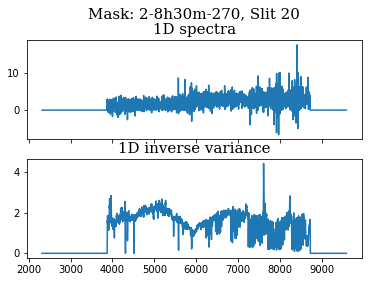

In [95]:
idx = 20

image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

imagetmp = image[idx, :]
ivartmp = ivar[idx, :]

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data), imagetmp)
axarr[0].set_title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
#plt.savefig('results/spectra1d/' + maskname + '-' + str(idx) + '-spectra1d.pdf', dpi = 600, bbox_inches = None)

(5, 823)


Text(0.5,1,'Mask: 2-8h30m-270, Slit 20')

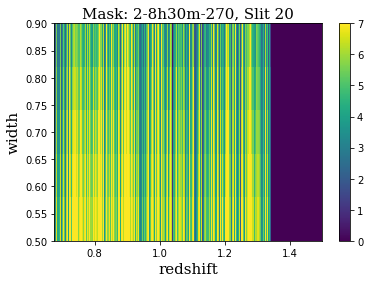

In [15]:
print(SNR_tmp[idx].shape)
plt.imshow(SNR_tmp[idx], aspect='auto', interpolation='None', \
           extent=[np.min(z), np.max(z), np.min(widths), np.max(widths)], vmin=0, vmax=7)
plt.colorbar()
plt.ylabel('width', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx),  fontsize = 15, fontname = 'serif')
#plt.savefig("results/SNR2D/" + maskname + '-' + str(idx) + "-SNR2d.pdf", dpi = 600, bbox_inches = None)

In [16]:
print("Max SNR for slit " + str(idx) + " is " + str(np.nanmax(SNR_tmp[idx])))

"""nanargmax flattens SNR_tmp[idx] and finds the index number of the max value while ignorning NaNs.
Then passing that index to unravel_index helps find the coordinate location of the max in the original
matrix shape. The second argument is the shape of the matrix. Thus for a given index and a given matrix
shape, unravel_index can unflatten the 1D data and reshape it to the desired matrix shape and then 
find out the coordinate of the desired value."""

w, redshift = np.unravel_index(np.nanargmax(SNR_tmp[idx]), np.array(SNR_tmp[idx]).shape)
print("Maximum SNR has -- width: " + str(widths[w]) + ' and redshift: ' + str(z[redshift]))


#Corresponding wavelength
lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
print("Wavelength corresponds to: " + str(lambda0*(1+z[redshift])))
print(lambda0)

Max SNR for slit 20 is 16.547344492503402
Maximum SNR has -- width: 0.8999999999999999 and redshift: 1.2550000000000006
Wavelength corresponds to: 8407.730292500004
3728.4835000000003


Text(0.5,1,'Mask: 2-8h30m-270, Slit 20\nz = 1.255, w = 0.9')

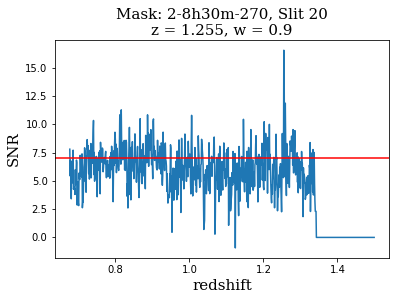

In [17]:
plt.plot(z, SNR_tmp[idx, w])
plt.axhline(7, c = 'red')
plt.ylabel('SNR', fontsize = 15, fontname = 'serif')
plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) +"\n" +\
          "z = " + str(np.round(z[redshift], 3)) + ', w = ' + str(np.round(widths[w],2)) \
          , fontsize = 15, fontname = 'serif')
#plt.xlim([z[redshift] - .1, z[redshift] + .1])
#plt.savefig("results/SNRvsRedshift/" + maskname + '-' + str(idx) + "-SNR_vs_z.pdf", dpi = 600, bbox_inches = None)

### Zooming into 1D spectra around wavelength range with the peak

In [18]:
lambda0*(1+z[redshift])-.1

8407.630292500004

In [73]:
z[redshift]

1.2550000000000006

In [97]:
Amps_tmp[idx, w, redshift]

52.956458679072476

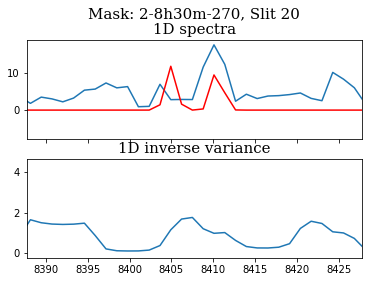

In [98]:
ranges = 20

f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(wave_grid(data), imagetmp)
axarr[0].set_title('Mask: ' + maskname + ', ' + 'Slit ' + str(idx) + "\n" + "1D spectra" \
                   ,  fontsize = 15, fontname = 'serif')
axarr[1].plot(wave_grid(data), ivartmp)
axarr[1].set_title('1D inverse variance', fontsize = 15, fontname = 'serif')
axarr[0].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])
axarr[1].set_xlim([lambda0*(1+z[redshift])-ranges, lambda0*(1+z[redshift])+ranges])

axarr[0].plot(wg3, Model(z[redshift], wg3, widths[w], Amp=Amps_tmp[idx, w, redshift]), c = 'red')

#plt.savefig("results/PeakZoom/" + maskname + '-' + str(idx) + "-zoom1d.pdf", dpi = 600, bbox_inches = None)

In [85]:
wg1 = wave_grid(data)
z_grid = lambda_to_z(wg1)
wg3 = wg1[(wg1 > (1+z[redshift])*(3728.4835-20.)) & (wg1 < (1+z[redshift])*(3728.4835+20.))]

3728.4835000000003


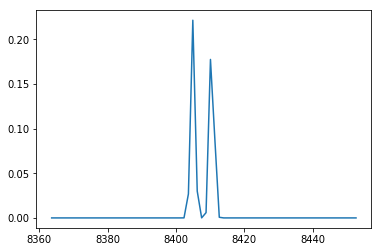

In [86]:
#wg2 = wave_grid(data)[(wave_grid(data) > (3727.092 - 20.)) & (wave_grid(data) < (3727.092 + 20.))]
plt.plot(wg3, Model(z[redshift], wg3, widths[w]))

3728.4835000000003


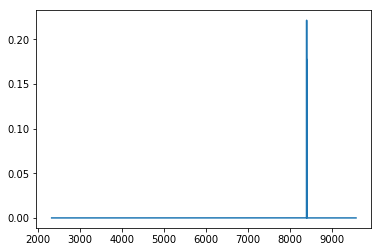

In [81]:
plt.plot(wg1, Model(z[redshift], wg1, widths[w]))
#plt.xlim([8300, 9600])

3728.4835000000003


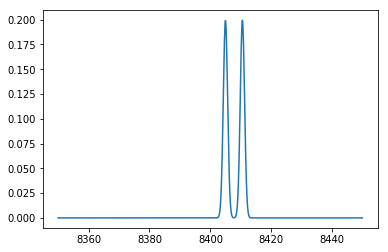

In [77]:
dummy = np.arange(8350, 8450, .1)
dummym = Model(z[redshift], dummy, 1.)
plt.plot(dummy, dummym)

In [75]:
wg3

array([8430.72981928, 8432.01981925, 8433.30981921, 8434.59981917,
       8435.88981913, 8437.17981909, 8438.46981905, 8439.75981902,
       8441.04981898, 8442.33981894, 8443.6298189 , 8444.91981886,
       8446.20981883, 8447.49981879, 8448.78981875, 8450.07981871,
       8451.36981867, 8452.65981863, 8453.9498186 , 8455.23981856,
       8456.52981852, 8457.81981848, 8459.10981844, 8460.39981841,
       8461.68981837, 8462.97981833, 8464.26981829, 8465.55981825,
       8466.84981822, 8468.13981818, 8469.42981814, 8470.7198181 ,
       8472.00981806, 8473.29981802, 8474.58981799, 8475.87981795,
       8477.16981791, 8478.45981787, 8479.74981783, 8481.0398178 ,
       8482.32981776, 8483.61981772, 8484.90981768, 8486.19981764,
       8487.4898176 , 8488.77981757, 8490.06981753, 8491.35981749,
       8492.64981745, 8493.93981741, 8495.22981738, 8496.51981734,
       8497.8098173 , 8499.09981726, 8500.38981722, 8501.67981719,
       8502.96981715, 8504.25981711, 8505.54981707, 8506.83981

In [46]:
np.max(Model(z[redshift], wg3, widths[w]))

0.0

### Checking raw signal-to-noise

In [ ]:
image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

In [ ]:
rawsnr = image*np.sqrt(ivar)
np.where(rawsnr == np.max(rawsnr))

Need: For every row, i.e. ngal, check if SNR > 7. If yes, then find max 10 SNR z and w for that gal and generate PDF. If not, ignore

In [ ]:
tmp = np.partition(SNR_tmp, 10, axis = 0)
tmp = tmp[:,-10:]
tmp.shape

In [ ]:
SNR_tmp.shape

In [ ]:
a = np.array([[ 6,  4,  10,  2,  2],
               [10,  9,  8,  7,  6]])

In [ ]:
a.shape

In [ ]:
b = np.partition(a, 4)    # top 3 values from each row

In [ ]:
b

In [ ]:
b[:,-3:]

## Test with synthetic signal

In [ ]:
synthSpectra = np.arange(7800, 7880, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model(1.1, synthSpectra, .2)
errstd = 0.1
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData[:, np.newaxis]

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData, c = 'red')
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)

In [121]:
A = np.arange(1, 10, .1)
B = np.arange(10, 19, .1)

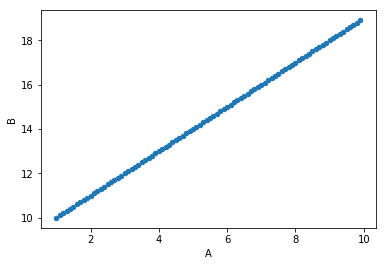

In [128]:
import pandas as pd
df = pd.DataFrame({'A':A, 'B':B})
df.plot('A', 'B', kind='scatter')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027731386320>,
      dtype=object)

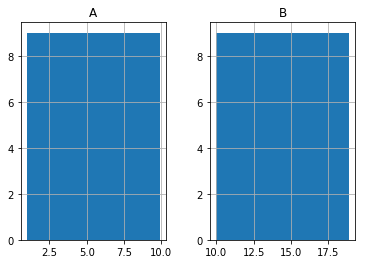

In [132]:
df.hist()

In [135]:
SNR_tmp[idx, w, redshift]

27.303268222017525